  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0/200 | gen loss: 4.101579587946314 | disc_loss: 0.19405856525981183


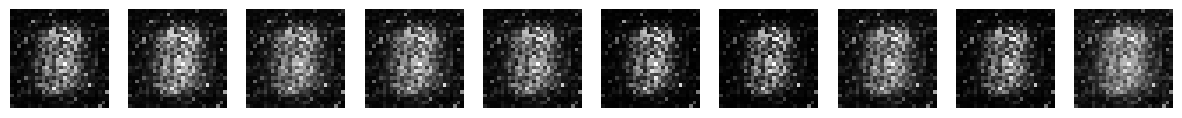

 20%|██        | 40/200 [12:12<49:10, 18.44s/it]

epoch: 40/200 | gen loss: 1.248790465501834 | disc_loss: 0.5250756482897537


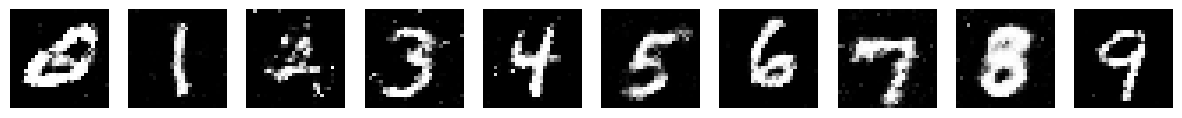

 40%|████      | 80/200 [24:16<36:10, 18.09s/it]

epoch: 80/200 | gen loss: 1.1589858311452845 | disc_loss: 0.5533371248415538


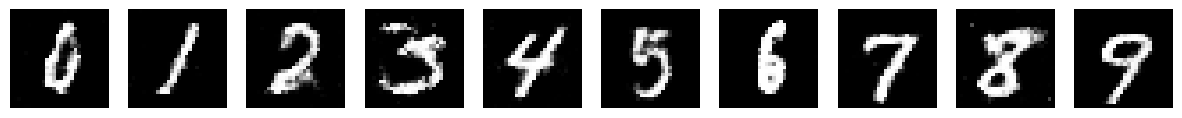

 60%|██████    | 120/200 [36:22<23:39, 17.75s/it]

epoch: 120/200 | gen loss: 1.246029763841934 | disc_loss: 0.5321826387379469


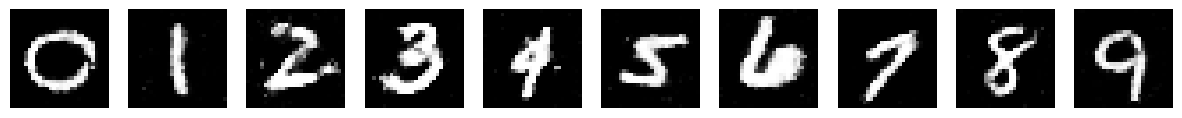

 80%|████████  | 160/200 [48:25<12:05, 18.13s/it]

epoch: 160/200 | gen loss: 1.355507989809203 | disc_loss: 0.508615368083596


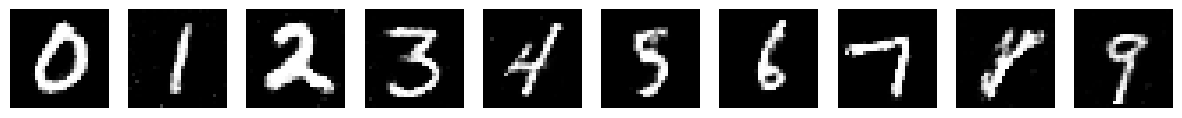

100%|██████████| 200/200 [1:00:35<00:00, 18.18s/it]


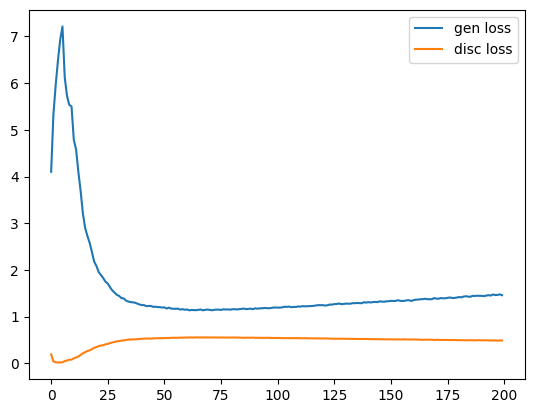

In [5]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm


class cond_gen(nn.Module):
    def __init__(self, latent_dim=100, num_classes=10, emb_dim=16) -> None:
        super().__init__()
        self.emb = nn.Embedding(num_classes, emb_dim)
        self.gen = nn.Sequential(
                nn.Linear(latent_dim+emb_dim, 256), # 100 + 16 because we're going to concat embd for conditioning
                nn.LeakyReLU(),
                nn.Dropout(p=0.2),
                nn.Linear(256, 512),
                nn.LeakyReLU(),
                nn.Dropout(p=0.2),
                nn.Linear(512, 1024),
                nn.LeakyReLU(),
                nn.Dropout(p=0.2),
                nn.Linear(1024, 784),
                nn.Tanh()
                )

    def forward(self, noise, labels):
        bs = noise.shape[0]
        embd = self.emb(labels)
        noise = torch.cat([noise, embd], dim=-1) # (b, 100) + (b, 16)
        genr = self.gen(noise)
        return genr.reshape(bs, 1, 28, 28)


class cond_disc(nn.Module):
    def __init__(self, num_classes=10, emb_dim=16) -> None:
        super().__init__()
        self.emb = nn.Embedding(num_classes, emb_dim)
        self.disc = nn.Sequential(
                nn.Linear(784+emb_dim, 1024),
                nn.LeakyReLU(), # performs better than ReLU
                nn.Dropout(p=0.2),
                nn.Linear(1024, 512),
                nn.LeakyReLU(),
                nn.Dropout(p=0.2),
                nn.Linear(512, 256),
                nn.LeakyReLU(),
                nn.Dropout(p=0.2),
                nn.Linear(256, 1)
                )

    def forward(self, x, labels):
        bs = x.shape[0]
        embd = self.emb(labels)
        x = x.reshape(bs, -1)
        x = torch.cat([x, embd], dim=-1)
        return self.disc(x)


gen_lr = 0.0001
disc_lr = 0.0001
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 64
latent_dim = 100

gen = cond_gen().to(device)
disc = cond_disc().to(device)

gen_optim = optim.Adam(gen.parameters(), gen_lr)
disc_optim = optim.Adam(disc.parameters(), disc_lr)

t2i = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, ), (0.5, ))
            ])

tr = MNIST("./data/", transform=t2i, download=True)
dl = DataLoader(tr, batch_size=batch_size, shuffle=True)

def train_cond_gan(gen, disc, gen_optim, disc_optim, dl, epochs, device="cuda", plot_gen_freq=50, plot_loss_freq=20, num_classes=10):

    loss_func = nn.BCEWithLogitsLoss()
    gen_losses = []
    disc_losses = []

    for e in tqdm(range(epochs)):
        gen_e_losses = []
        disc_e_losses = []

        for imgs, tl in dl:
            imgs = imgs.to(device)
            tl = tl.to(device)
            bs = imgs.shape[0]

            noise = torch.randn(bs, latent_dim, device=device)
            rand_labels = torch.randint(0, num_classes, size=(bs, ), device=device)

            gen_labels = torch.zeros(bs, 1, device=device)
            real_labels = torch.ones(bs, 1, device=device)

            gen_im = gen(noise, rand_labels).detach()

            real_disc_pred = disc(imgs, tl)
            gen_disc_pred = disc(gen_im, rand_labels)

            real_loss = loss_func(real_disc_pred, real_labels)
            fake_loss = loss_func(gen_disc_pred, gen_labels)
            disc_loss = (real_loss + fake_loss) / 2
            disc_e_losses.append(disc_loss.item())

            disc_optim.zero_grad()
            disc_loss.backward()
            disc_optim.step()

            rand_digits = torch.randint(0, num_classes, size=(bs, ), device=device)
            noise = torch.randn(bs, latent_dim, device=device)

            gen_im = gen(noise, rand_digits)

            gen_disc_pred = disc(gen_im, rand_digits)

            gen_loss = loss_func(gen_disc_pred, real_labels)
            gen_e_losses.append(gen_loss.item())

            gen_optim.zero_grad()
            gen_loss.backward()
            gen_optim.step()

        gen_epoch_losses = np.mean(gen_e_losses)
        disc_epoch_losses = np.mean(disc_e_losses)

        if e % plot_loss_freq == 0:
            print(f"epoch: {e}/{epochs} | gen loss: {gen_epoch_losses} | disc_loss: {disc_epoch_losses}")

        gen_losses.append(gen_epoch_losses)
        disc_losses.append(disc_epoch_losses)

        if e % plot_gen_freq == 0:
            with torch.no_grad():
                digits = torch.arange(num_classes, device=device)
                ns = torch.randn(num_classes, latent_dim, device=device)

                gen_imgs = gen(ns, digits).to("cpu")
                fig, ax = plt.subplots(1, num_classes, figsize=(15, 5))
                for i in range(num_classes):
                    img = (gen_imgs[i].squeeze() + 1) / 2 # b , 1, 28, 28
                    ax[i].imshow(img.numpy(), cmap="gray")
                    ax[i].set_axis_off()
                plt.show()
            gen.train()
    return gen, disc, gen_losses, disc_losses


gener, discr, gen_l, disc_l = train_cond_gan(gen, disc, gen_optim, disc_optim, dl, epochs=200, device="cuda", plot_gen_freq=40, plot_loss_freq=40)


plt.plot(gen_l, label="gen loss")
plt.plot(disc_l, label="disc loss")
plt.legend()
plt.show()